## Parsing Dates & Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional for later phases
# !pip install prophet xgboost sentence-transformers faiss-cpu transformers

In [4]:
df = pd.read_csv("Warehouse_and_Retail_Sales.csv")

#creating a true data column
df["date"] = pd.to_datetime(df["YEAR"].astype(str) + "-" +
                            df["MONTH"].astype(str).str.zfill(2) + "-01")

#checking the peek
print(df.shape)
print(df.dtypes)
df.head()

(307645, 10)
YEAR                         int64
MONTH                        int64
SUPPLIER                    object
ITEM CODE                   object
ITEM DESCRIPTION            object
ITEM TYPE                   object
RETAIL SALES               float64
RETAIL TRANSFERS           float64
WAREHOUSE SALES            float64
date                datetime64[ns]
dtype: object


,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES,date
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0,2020-01-01
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0,2020-01-01
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0,2020-01-01
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0,2020-01-01
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0,2020-01-01


## Renaming & Selecting Relevant Fields

In [5]:
df = df.rename(columns={
    "RETAIL SALES": "retail_sales",
    "WAREHOUSE SALES": "wh_sales",
    "RETAIL TRANSFERS": "retail_transfers",
    "ITEM CODE": "sku",
    "ITEM DESCRIPTION": "description",
    "ITEM TYPE": "item_type",
    "SUPPLIER": "supplier"
})

#selcting the columns I need for phase 1
df = df[["date", "supplier", "sku", "description", "item_type", 
         "retail_sales", "wh_sales", "retail_transfers"]]

## Defining the total sales & Basic Cleaning

In [10]:
#total sales as sum of retail + warehouse
df["total_sales"] = df["retail_sales" ] + df["wh_sales"]

#checking for missing values
print(df.isna().sum())

#filling if needed or dropping
df["total_sales"].fillna(0, inplace=True)

date                  0
supplier            167
sku                   0
description           0
item_type             1
retail_sales          3
wh_sales              0
retail_transfers      0
total_sales           3
dtype: int64


## Ensuring continuous time series per SKU

In [14]:
#since its monthly data, I'll reindex per SKU on a month frequency

def reindex_monthly(sku_df):
    idx = pd.date_range(
        start=sku_df["date"].min(),
        end=sku_df["date"].max(),
        freq="MS"      # Month Start frequency
    )
    return (
        sku_df
        .set_index("date")
        .reindex(idx)
        .assign(sku=sku_df["sku"].iloc[0])
        .rename_axis("date")
        .reset_index()
    )

# 1) reindex each SKU to have a full monthly timeline
df_reindexed = (
    df
    .groupby("sku", group_keys=False)
    .apply(reindex_monthly)
)

# 2) merge back the original retail/wh_sales/etc. from df (which still has 'date')
df_full = (
    df_reindexed
    .merge(
        df, 
        on=["sku", "date"],    # both dfs still have these columns
        how="left",
        suffixes=("", "_orig")
    )
)

# 3) if you see columns like retail_sales_orig, wh_sales_orig, drop the empty versions:
df_full = df_full.drop(
    columns=[c for c in df_full.columns if c.endswith("_orig") and df_full[c].isna().all()]
)

# 4) finally fill any remaining NaNs in your sales columns
for col in ["retail_sales", "wh_sales", "retail_transfers", "total_sales"]:
    df_full[col] = df_full[col].fillna(0)

df_full.head()

,date,supplier,sku,description,item_type,retail_sales,wh_sales,retail_transfers,total_sales,supplier_orig,description_orig,item_type_orig,retail_sales_orig,wh_sales_orig,retail_transfers_orig,total_sales_orig
0,2017-07-01,RELIABLE CHURCHILL LLLP,100002,PATRON TEQUILA SILVER LTD - 1L,LIQUOR,0.17,0.0,0.0,0.17,RELIABLE CHURCHILL LLLP,PATRON TEQUILA SILVER LTD - 1L,LIQUOR,0.17,0.0,0.0,0.17
1,2019-04-01,CONSTANTINE WINES INC,100007,LA CETTO CAB SAUV - 750ML,WINE,0.00,1.0,0.0,1.00,CONSTANTINE WINES INC,LA CETTO CAB SAUV - 750ML,WINE,0.00,1.0,0.0,1.00
2,2019-05-01,CONSTANTINE WINES INC,100007,LA CETTO CAB SAUV - 750ML,WINE,0.00,1.0,0.0,1.00,CONSTANTINE WINES INC,LA CETTO CAB SAUV - 750ML,WINE,0.00,1.0,0.0,1.00
3,2019-06-01,NaN,100007,NaN,NaN,0.00,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-01,NaN,100007,NaN,NaN,0.00,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature engineering

In [15]:
df_full["year"] = df_full["date"].dt.year
df_full["month"] = df_full["date"].dt.month
df_full["month_name"] = df_full["date"].dt.strftime("%b")

## Computing APIs

In [16]:
#Turnover = (sum of total_sales)/(avg warehouse stock)
sales_sum = df_full.groupby("sku")["total_sales"].sum()
turnover = (sales_sum/ df_full.groupby("sku")["total_sales"].mean()).rename("turnover_rate")

## Days-On-Hand Approximation

In [17]:
avg_monthly_sales = df_full.groupby("sku")["total_sales"].mean()
# Suppose month’s stock = last month’s total_sales as proxy
proxy_stock = df_full.groupby("sku").last()["total_sales"]
days_on_hand = (proxy_stock / (avg_monthly_sales / 30)).rename("days_on_hand")

## ABC classification

In [23]:
annual_sales = df_full.groupby("sku")["total_sales"].sum().sort_values(ascending=False)
cum_pct = annual_sales.cumsum() / annual_sales.sum()

def abc(x):
    if x <= 0.70: return "A"
    elif x <= 0.90: return "B"
    else: return "C"
    
abc_class = cum_pct.map(abc).rename("abc_class")

## Combining the KPIs

In [24]:
kpis = pd.concat([turnover, days_on_hand, abc_class], axis=1).reset_index()
kpis.head()

,sku,turnover_rate,days_on_hand,abc_class
0,100002,1.0,30.000000,C
1,100007,8.0,60.000000,C
2,100008,5.0,50.000000,C
3,100009,35.0,4.259635,C
4,100011,24.0,240.000000,C


## Visualizations

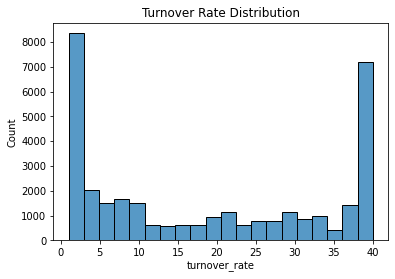

In [25]:
#turnover distributions
sns.histplot(kpis["turnover_rate"], bins=20)
plt.title("Turnover Rate Distribution")
plt.show()

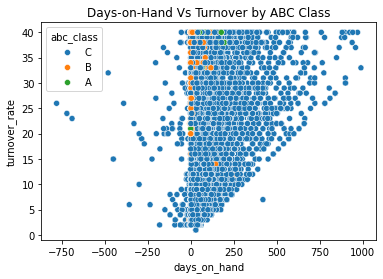

In [26]:
#days_on_hand vs Turnover
sns.scatterplot(data=kpis,
               x="days_on_hand",
               y="turnover_rate",
               hue="abc_class")
plt.title("Days-on-Hand Vs Turnover by ABC Class")
plt.show()

SyntaxError: unexpected EOF while parsing (<ipython-input-27-c3539538f4bd>, line 25)